# Introduction

This notebook accompanies the paper [arXiv:2411.13421](https://arxiv.org/abs/2411.13421), providing the numerical methods used to reproduce its results. The notebook is self-contained and includes illustrative examples to demonstrate the methods in action. 

The notebook is organized as follows:
- **Step 0**:  Import the necessary packages and define most of the required functions.
- **Step 1**: Single-rank analysis. Perform a case study to find a GPT model of a specific rank $k$ that best fits a given frequency table (see Section II.B of the paper).
- **Step 2**: Multi-rank analysis. Iterate Step 1 for multiple ranks $k \in\{2,3,\ldots,9\}$ to estimate which rank provides the best fit (see Section II.C of the paper).
- **Step 3**: Single-rank analysis for different time evolutions as preparations. How to stack data matrices for different time-evolutions into a single one to carry out the analysis. 
- **Step 4**: Find a transformation that aligns the *states' consistent* space with the unit sphere. Use this transformation to compare different state realized spaces. 
- **Step 5**: Compute the volume of the state spaces for various time evolutions, examining how the volume changes as the qubit decoheres.

The code has been implemented in Python 3.9. Higher versions may conflict with the *cdd* package, though this issue can be ignored unless Step 4 is of interest.

# Step 0: Import packages and define the main functions to be used

In [46]:
# First import the main packages we need

import cvxopt  as cv
import numpy as np
import matplotlib.pyplot as plt
import os
import csv
import scipy as sp

# Extra packages which are more situational 
import cdd # https://pycddlib.readthedocs.io/en/latest/polyhedron.html (on windows we had to downgrade the python version to (e.g.) 3.9 to install this package)
from fractions import Fraction
import scipy.linalg
import scipy.optimize
from scipy.optimize import Bounds
from scipy.optimize import LinearConstraint
from scipy.optimize import linprog
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

The following cells define the functions used to pose and solve the conic problems that allow us to find the GPT fit model:

In [21]:
# the linear program used to obtain the state space that minimizes chi_squared for rank n while the effects are given and fixed
def state_optim(eff, data, n):
    # here n is the rank  
    data_dimensions = data.shape # frequency matrix dimensions
    cardinality_preparations = data_dimensions[0] # number of preparations
    cardinality_effects = data_dimensions[1] # number of measurements
    cardinality = cardinality_preparations #it assumes num preps = num measurements, otherwise the dimensions need to be adapted    
    Im = np.identity(cardinality_preparations) # identity matrix
    Wprime = np.diag(oneoverW(data).flatten(('F')))
    Pfunc = cv.matrix(2*np.dot(np.dot(np.kron(eff,Im),Wprime),np.transpose(np.kron(eff,Im))))
    qfunc = cv.matrix(-2*np.dot(np.dot(np.kron(eff,Im),Wprime),data.flatten(('F'))))
    hfunc = cv.matrix(np.array([np.ones(cardinality_preparations*cardinality_effects),np.zeros(cardinality_preparations*cardinality_effects)]).reshape(2*cardinality_preparations*cardinality_effects,1))
    Gfunc = cv.matrix(np.kron(np.array([[1],[-1]]),np.transpose(np.kron(eff,Im))))
    Afunc = cv.matrix(Aarray(n,cardinality_preparations))
    bfunc = cv.matrix(np.ones([cardinality_preparations,1]))
    cv.solvers.options['show_progress'] = False # to silence CVX's progress    
    solfunc = cv.solvers.qp(Pfunc,qfunc,Gfunc,hfunc,Afunc,bfunc)
    return np.array(solfunc['x']).reshape(n,cardinality_preparations).T

# the linear program used to obtain the effect space that minimizes chi_squared for rank n while the states are given and fixed
def effect_optim_NOAB(state, data, n):
    # here n is the rank 
    data_dimensions = data.shape # frequency matrix dimensions
    cardinality_preparations = data_dimensions[0] # number of preparations
    cardinality_effects = data_dimensions[1] # number of measurements  
    cardinality = cardinality_preparations #it assumes num preps = num measurements, otherwise the dimensions need to be adapted 
    Im = np.identity(cardinality_effects) # identity matrix
    Wprime = np.diag(oneoverW(data).flatten(('F')))
    Pefffunc = cv.matrix(2*np.dot(np.dot(np.transpose(np.kron(Im,state)),Wprime), np.kron(Im,state)))
    qefffunc = cv.matrix(-2*np.dot(np.dot(np.transpose(np.kron(Im,state)),Wprime), data.flatten(('F'))))
    Gefffunc = cv.matrix(np.kron(np.array([[1],[-1]]),np.kron(Im,state)))
    hefffunc = cv.matrix(np.array([np.ones(cardinality_preparations*cardinality_effects),np.zeros(cardinality_preparations*cardinality_effects)]).reshape(2*cardinality_preparations*cardinality_effects,1))
    cv.solvers.options['show_progress'] = False # to silence CVX's progress
    solefffunc = cv.solvers.qp(Pefffunc,qefffunc,Gefffunc,hefffunc)
    return np.array(solefffunc['x']).reshape(cardinality_effects,n).T
    

# Here we perform a see-saw optimization between states and effects to minimize the chi_square. That is,
# the function alternates between minimizing the chi-squared value over the state space and over the effect space, 
# iteratively updating both spaces. The process continues until the improvement in the chi-squared value falls below 
# a specified convergence threshold.
def seesaw_optim(func_state_optim, func_effect_optim, quintuple, convergence_tolerance):
    # quintuple = [states, effects, prob, data, rank]    
    """
    func_state_optim and func_effect_optim are the different conic problems (depending on which constraints are inputed and such)
    For example one can call:
        state_optim
        state_optim_NOAB
        state_optim_noW_no_AB
    """
    datamat = quintuple[3] # get data
    data_dimensions = datamat.shape # frequency matrix dimensions
    cardinality_preparations = data_dimensions[0] # number preparations    
    current_states = quintuple[0] # grab the initial states
    rank = quintuple[4] # get rank    
    if np.all(current_states) == 0: # for when no states have inputed 
        np.random.rand(cardinality_preparations,rank) # initialize to random States
    previous_chisquared = 1e10 # initialize error to some crazy high value
    exitCriteria = 0 # initialize to "not converged"
    iterations = 0
    while exitCriteria < 1: # convergence criteria
            current_effects = func_effect_optim(current_states, datamat, rank)
            current_states = func_state_optim(current_effects, datamat, rank)
            prob = np.dot(current_states, current_effects) 
            # convergence check. we assume convergence when the progress finding chi^2 is smaller than convergence_tolerance
            current_chisquared = chisquared([current_states, current_effects, prob, datamat, rank], datamat)
            iterations += 1
            print("Rank = " + str(rank) + ", iteration = " + str(iterations) + ". Current Chi^2 = " + str(current_chisquared))
            if np.abs(previous_chisquared - current_chisquared) < convergence_tolerance:
                print("Rank = " + str(rank) + ", iteration = " + str(iterations) + ". Converged to Chi^2 = " + str(current_chisquared))
                exitCriteria = 1
            else:
                previous_chisquared = current_chisquared
    prob = np.dot(current_states, current_effects) # get the probability table for the found states and effects
    return [current_states, current_effects, prob, quintuple[3], quintuple[4], current_chisquared]

# Here we call seesaw_optim for several different ranks n
def seesaw_over_range(func_state_optim, func_effect_optim, datamat, first_rank, final_rank, convergence_tolerance):
    # from first_rank to final_rank (both inclusive)
    data_dimensions = datamat.shape # get the frequency matrix dimensions
    cardinality_preparations = data_dimensions[0]    
    cardinality_effects = data_dimensions[1]
    return [seesaw_optim(func_state_optim, func_effect_optim, [np.random.rand(cardinality_preparations, rank), 0, 0, datamat, rank], convergence_tolerance) for rank in range(first_rank, final_rank+1, 1)]

In [31]:
# The objective function in the linear program (c.f., Eq. 4)
def chisquared(quintuple,data):
    D = np.dot(quintuple[0],quintuple[1])
    F = data
    return np.sum(np.multiply(np.power((F - D), 2), oneoverW(F)))

# Compute the variance of some given frequency table data
def oneoverW(datamat):
    return singleshots_number/np.multiply(datamat, 1-datamat)

In [2]:
# These functions are to generate the arrays used as constraints in the linear program
def create_array(n):
    arr = np.zeros(n)  # Create an array of zeros with n elements
    arr[0] = 1  # Set the first element to 1
    return arr

def Barray(n,cardinality):
    array = np.zeros((cardinality, n*cardinality))
    for i in range(cardinality):
            array[i,n*i] = 1 
    return array

def Aarray(n,cardinality):
    array = np.hstack((np.eye(cardinality),np.zeros((cardinality,(n-1)*cardinality))))
    return array

In [25]:
# The function to obtain the dual space of S_realised and E_realised
# it needs the cdd package https://pycddlib.readthedocs.io/en/latest/polyhedron.html

def dual_space(matrix,dim):
    mat = cdd.Matrix(matrix, linear=False, number_type="float") 
    mat.rep_type = cdd.RepType.INEQUALITY
    poly = cdd.Polyhedron(mat)
        
    ext = poly.get_generators()
    
    dual_M = np.empty((0, dim))
    for row in ext:
        row = list(row)
        row = row[1:5]
        dual_M = np.append(dual_M,[row],axis=0)
        
    return dual_M

In [67]:
# Algorithm to find the linear transformation that brings the states as close to a unit sphere as possible

# Euler angles to get a rotation matrix V which is orthogonal and explores all SO(3)
def euler_angles_matrix(alpha, beta, gamma):
    V = [[np.cos(alpha)*np.cos(gamma)-np.sin(alpha)*np.cos(beta)*np.sin(gamma), -np.cos(alpha)*np.sin(gamma)-np.sin(alpha)*np.cos(beta)*np.cos(gamma), np.sin(alpha)*np.sin(beta)],[np.sin(alpha)*np.cos(gamma)+np.cos(alpha)*np.cos(beta)*np.sin(gamma), -np.sin(alpha)*np.sin(gamma)+np.cos(alpha)*np.cos(beta)*np.cos(gamma), -np.cos(alpha)*np.sin(beta)], [np.sin(beta)*np.sin(gamma), np.sin(beta)*np.cos(gamma), np.cos(beta)]];     
    return np.array(V)

def obective_function(variables,data_points):
    data_points = remove_interior_points(data_points) # get boundary points only
    if len(data_points.T)>3:
        data_points = data_points[::,1:4] # keep the 3D subset we are interested in

    #centering = np.mean(data_points, axis=0)
    data_points = data_points - np.mean(data_points, axis=0) # use the element-wise mean to center the cloud of points
    
    # initialize variables
    res = 0
    sigma1 = variables[0]
    sigma2 = variables[1]
    sigma3 = variables[2]
    alpha = variables[3]
    beta = variables[4]
    gamma = variables[5]
    V = euler_angles_matrix(alpha, beta, gamma)
    
    # the actual objective function
    for i in range(0,len(data_points)):
        # broken up in steps to make the objective function more visually appealing
        S_i = data_points[i,::]
        SigmaSquared = np.dot(np.diag([sigma1, sigma2, sigma3]),np.diag([sigma1, sigma2, sigma3]))
        norm_val = np.linalg.norm(np.dot(np.dot(np.dot(np.dot(S_i,V),SigmaSquared),V.T),S_i.T))        
        
        res = res + np.dot(1-np.dot(norm_val,norm_val),1-np.dot(norm_val,norm_val))
    return res

def find_transformation(data_points):
    # using scipy's minimize function:
    x0 = np.ndarray.flatten(np.random.rand(1,6)) # the initial guess is random for now
    linear_constraint = LinearConstraint([[1,0,0,0,0,0],[0,1,0,0,0,0],[0,0,1,0,0,0],[0,0,0,1,0,0],[0,0,0,0,1,0],[0,0,0,0,0,1]], [0,0,0,-2*np.pi,-2*np.pi,-2*np.pi], [2,2,2,2*np.pi,2*np.pi,2*np.pi])
    
    res = scipy.optimize.minimize(obective_function, x0, args=(data_points), constraints=[linear_constraint])
    return res

def apply_transformation(data_points,Sigma,V,shift_t):
    n = len(data_points)
    if len(data_points.T)>3: # I don't want the column of ones
        data_points = data_points[::,1:4]
    data_points -=shift_t    
    # Need to discuss whether we want to recenter all clouds of data, whether we just do it to find the transformation (like I do now), or whether we don't do it at all
    #data_points = data_points - np.mean(data_points, axis=0) # element-wise mean to center cloud of data points
    
    newSconsistent = np.atleast_2d(np.dot(np.dot(Sigma,V.T), data_points[0,::].T)) # Initialize the variable with the first point. s_i' into column vector
    for i in range(1,n): # iterate and append the rest
        S_i = data_points[i,::]
        newSi = np.atleast_2d(np.dot(np.dot(Sigma,V.T), S_i.T)) # s_i' into column vector
        newSconsistent = np.vstack((newSconsistent, newSi))
    return newSconsistent

# (Optional) An algorithm to remove interior points. This is a precautory step to guarantee that we deal only with the boundary points only
def remove_interior_points(data_points):
    # initialize variables
    current_points = data_points # variable on which to update the set
    index = 0 # dummy variable to count

    # Linear Programming
    # Algorithm sketch: Take all the set of data points except of the row specified by the variable "index". Then check whether one can make a convex combination of the data points to recover the missing one. If it can, then we discard it since it is a mixture of other points in the set and, thus, not a boundary/extremal point.
    while index < len(current_points): # we probe all rows in the set
        # start specifying the linear program conditions
        fun = np.zeros((1, len(current_points)-1)).T # this is to set the objective function to 0 and have a feasibility problem (instead of optimization)
        Aeq = np.delete(current_points, index, 0).T # the data points minus the row being tested. the first row of ones will be used for the convex combination elements
        beq = current_points[index,::].T
        LB = np.zeros(len(current_points.T)) # elements of x should be greater than 0 <= x_i
        UB = np.ones(len(current_points.T)) 

        # compute the linear program
        res = linprog(fun, A_ub=None, b_ub=None, A_eq=Aeq, b_eq=beq, bounds=[(0, None)])
        # if successful we remove the row
        if res.success == True:
            current_points = np.delete(current_points, index, 0)
            index = index - 1
        index = index + 1 # clumsy way of counting. I do not do a For loop because the size of the set changes as the states get deleted
            
    return current_points
        

# Step 1: Single-rank analysis. Obtaining the states and effects to fit a GPT model with rank $k=4$ (illustrative example)

We are now ready to load and prepare the data on which to find a model fit:

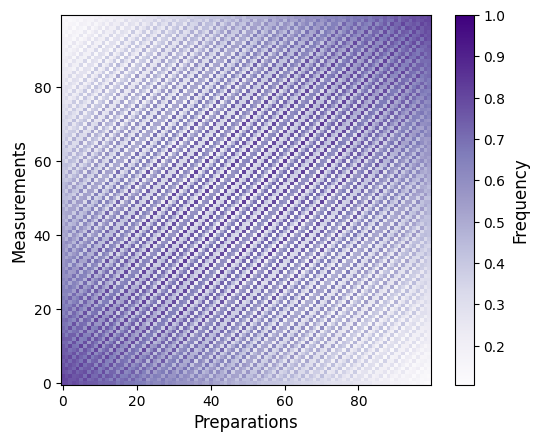

In [22]:
# load the experimental data (frequency table) 
runnum = 1 # specify which experimental run, for this example we choose the first experimental run
datafile = f'Data/zzzGPTrun{runnum}.csv' # A string specifying the name of the file to be loaded
datamat = np.genfromtxt(datafile, delimiter=",") # load the frequency table data

# Get the number of preparations and measurements from the given data
matrix_dimensions = datamat.shape # data dimensions
cardinality_preparations = matrix_dimensions[0] # number of preparations
cardinality_effects = matrix_dimensions[1] # number of measurements
Im = np.identity(cardinality_preparations) # for when we do not want these constraints on S and E.

# plot the loaded frequency table
fontsize_fig=12
plt.imshow(datamat, cmap='Purples', origin='lower', vmax=1.0)
cbar = plt.colorbar(label='Frequency')
cbar.ax.yaxis.label.set_size(fontsize_fig) 
plt.xlabel('Preparations',fontsize=fontsize_fig)
plt.ylabel('Measurements',fontsize=fontsize_fig)
#plt.savefig(f'frequency_fig.png', format='png', dpi=300, bbox_inches='tight')
plt.show()

The following cell illustrates how to call the seesaw optimization to find a model fit for a specific rank $k$:

In [23]:
# First, lets give the parameters that need to be inputed manually
rank = 4 # the given rank we want to probe
singleshots_number = 1999 # how many single-shots were used in the experiment to estimate each conditional probability in the given data. For now this needs to be manually set 
convergence_tolerance = 1e-7 # the see-saw optimization will converge when the improvement is smaller than this value. The smaller the value, the more accurate the optimization

# Call the seesaw optimization for a given rank
current_states = np.random.rand(cardinality_preparations,rank) # initialize to random States
current_effects = np.random.rand(rank,cardinality_effects) # initialize to random Effects. check if the order is correct
prob = np.dot(current_states, current_effects) # get their probability table
quintuple = [current_states, current_effects, prob, datamat, rank]
numerical_result = seesaw_optim(state_optim, effect_optim_NOAB, quintuple, convergence_tolerance)

state = numerical_result[0].copy()
effect = numerical_result[1].copy()

### the linear program results are stored in the variable 'numerical_result' as:
# numerical_result[0] returns the found states
# numerical_result[1] returns the found effects
# numerical_result[2] returns the given probability table for the initial given states and effects. It can be ignored
# numerical_result[3] returns the given data, i.e. the frequency table obtained in the experiment
# numerical_result[4] returns the given rank k for the fit
# numerical_result[5] returns the found chi_squared

Rank = 4, iteration = 1. Current Chi^2 = 2295441.7039833316
Rank = 4, iteration = 2. Current Chi^2 = 17506.332391790016
Rank = 4, iteration = 3. Current Chi^2 = 9852.206907751397
Rank = 4, iteration = 4. Current Chi^2 = 9851.849514821224
Rank = 4, iteration = 5. Current Chi^2 = 9851.849449263002
Rank = 4, iteration = 6. Current Chi^2 = 9851.849449250745
Rank = 4, iteration = 6. Converged to Chi^2 = 9851.849449250745


In [24]:
### Next, we transform the previously obtained states and effects to get the desired S_realised and E_realised

# use the obtained states and effects to build D_realized
Drealised = np.dot(state,effect)

# make first column of Drealized ones
Drealised = np.block([np.ones((len(Drealised),1)), Drealised.copy()])

# obtain the QR decomposition of Drealised and scale
Q, R = np.linalg.qr(Drealised)
Dprealised = np.dot(Q,R)
c = Q[0,0]
Qprime = Q/c
Rprime = c*R

# Partition the matrices as explained in the text
Q0 = np.array([Qprime[:,0]]).copy().T # instead of getting a 1D array (just doing Qprime[:,0]), I am forcing it to be a column vector (2D-array)
Q1 = np.delete(Qprime, 0, axis=1).copy()

R0 = np.array([Rprime[0,:]]).copy()
R1 = np.delete(Rprime, 0, axis=0).copy()

# Singular value decomposition
tmp_matrix = np.dot(Q1,R1)
U, Sigma, V = np.linalg.svd(tmp_matrix)
V = V.T
Sigma = np.diag(Sigma) # Now we turn the variable into an actual matrix, instead of an array that can build the diag matrix

# The parts we are interested in from the SVD
U_int = U[:,0:rank-1].copy()
Sigma_int = Sigma[0:rank-1,0:rank-1].copy()
V_int = V[:,0:rank-1].copy()

# Obtain Srealized and Erealized
Sprealised = np.block([Q0, np.dot(U_int,np.sqrt(Sigma_int))])
Eprealised = np.block([[R0], [np.dot(np.sqrt(Sigma_int), V_int.T)]]) 

# get components to plot
Srx = Sprealised[:,1] # S_realised component x
Sry = Sprealised[:,2]
Srz = Sprealised[:,3]

unit_e = [1,0,0,0] # the unit effect
unit_matrix = np.array([unit_e]*len(Eprealised.T))

Eprealised = np.append(Eprealised,unit_matrix.T-Eprealised,axis=1)

# get some components to plot
Erx = Eprealised[0,:] # E_realised component x
Ery = Eprealised[1,:]
Erz = Eprealised[2,:]

In [26]:
### We are now ready to obtain S_consistent and E_consistent by obtaining the dual spaces of E_realised and S_realised respectively

# For a polyhedron described as P = {x | A x <= b}, the H-representation is the matrix [b -A].
A = np.vstack((-Eprealised.T,Eprealised.T))
b=np.array([np.zeros(len(Eprealised.T)),np.ones(len(Eprealised.T))]).reshape(2*len(Eprealised.T),1)
A = -np.array(A)
b = np.array(b)
M = np.hstack((b,A))

# Lets start obtaining S_consistent (i.e., the dual space of E_realised)
Spconsistent = dual_space(M, len(Eprealised))

# get components to plot
Scx = Spconsistent[:, 1] # S_consistent component x
Scy = Spconsistent[:, 2]
Scz = Spconsistent[:, 3]

# Same procedure to obtain E_consistent
C = np.vstack((-Sprealised,Sprealised))
d = np.array([np.zeros(len(Sprealised)),np.ones(len(Sprealised))]).reshape(2*len(Sprealised),1)
C = -np.array(C)
d = np.array(d)
N = np.hstack((d,C))

Epconsistent = dual_space(N,len(Sprealised.T))
Ecx = Epconsistent[:, 0]
Ecy = Epconsistent[:, 2]
Ecz = Epconsistent[:, 3]

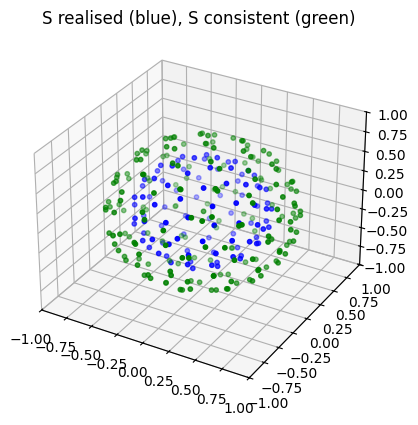

In [29]:
### Plot the state spaces, both S_realised and S_consistent, for rank 4

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(Srx,Sry,Srz, marker='o',s=10, c='blue')
ax.scatter(Scx,Scy,Scz, marker='o',s=10, c='green')
plt.title('S realised (blue), S consistent (green)')
#ax.view_init(0., 0)
ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])
ax.set_zlim([-1, 1])
#plt.savefig(f'Src{datanum}.png', format='png')
plt.show()

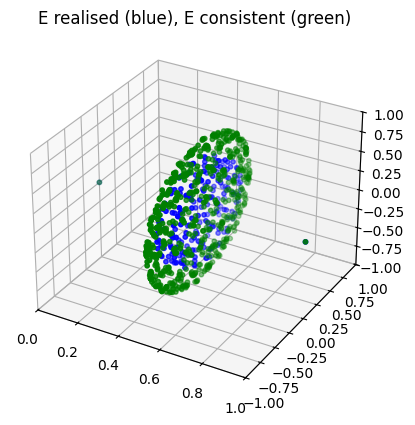

In [30]:
### Plot the effect spaces, both E_realised and E_consistent, for rank 4

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(Erx,Ery,Erz, marker='o',s=10, c='blue')
ax.scatter(Ecx,Ecy,Ecz, marker='o',s=10, c='green')
plt.title('E realised (blue), E consistent (green)')
# ax.view_init(0., -90)
ax.set_xlim([0, 1])
ax.set_ylim([-1, 1])
ax.set_zlim([-1, 1])
#plt.savefig(f'Erc{datanum}.png', format='png')
plt.show()

# Step 2: Multi-rank analysis. Which rank $k$ gives the best GPT fit?

Here we compute a GPT model fit for ranks $k\in \{2,3,\ldots,9\}$. Then, we use training and test sets to analyse which rank model provides the best fit. From the results we observe that, indeed, rank $4$ gives the best GPT model fit

In [116]:
### The seesaw optimization for a range of different ranks
### WARNING: This cell is time-consuming to compute. One can skip to the next cell, where we load pre-computed data. Otherwise, a way to decrease the computing time is to reduce the convergence_tolerance (although it has the cost of getting less robust results). In the next cell we directly load the]

# We start by giving the parameters that need to be manually inputed
convergence_tolerance = 1e-7 # the see-saw optimization will converge when the improvement is smaller than this value. The smaller the value, the more accurate the optimization
singleshots_number = 1999 # how many single-shots were used in the experiment to estimate each conditional probability in the given data. For now this needs to be manually set 
first_rank = 2 # inclusive
final_rank = 9 # inclusive
rank_length = final_rank-first_rank
rank_values = range(rank_length+1)
run_values = range(1,11) 

# next, we call the seesaw optimization for a range of different ranks
# run:
trainmodel_ranks = []
for runnum in run_values:
    print('Run: ',runnum)
    datafile = f'Data/zzzGPTrun{runnum}.csv'
    datamat = np.genfromtxt(datafile, delimiter=",")
    trainmodel_ranks.append(seesaw_over_range(state_optim, effect_optim_NOAB, datamat, first_rank, final_rank, convergence_tolerance))

# export the trainmodel data:
np.save('trainmodelRanks.npy', np.array(trainmodel_ranks,dtype=object), allow_pickle=True)

Run:  1
Rank = 2, iteration 1. Current Chi^2 = 4897703.711122765
Rank = 2, iteration 2. Current Chi^2 = 2928442.657061897
Rank = 2, iteration 3. Current Chi^2 = 2923641.860654936
Rank = 2, iteration 4. Current Chi^2 = 2918953.556141635
Rank = 2, iteration 5. Current Chi^2 = 2913952.5132795516
Rank = 2, iteration 6. Current Chi^2 = 2908693.168381652
Rank = 2, iteration 7. Current Chi^2 = 2903242.1579428785
Rank = 2, iteration 8. Current Chi^2 = 2897674.8502619257
Rank = 2, iteration 9. Current Chi^2 = 2892071.1236554896
Rank = 2, iteration 10. Current Chi^2 = 2886510.795558156
Rank = 2, iteration 11. Current Chi^2 = 2881069.2432789635
Rank = 2, iteration 12. Current Chi^2 = 2875813.693464765
Rank = 2, iteration 13. Current Chi^2 = 2870800.5129808034
Rank = 2, iteration 14. Current Chi^2 = 2866073.6504027937
Rank = 2, iteration 15. Current Chi^2 = 2861664.1992416275
Rank = 2, iteration 16. Current Chi^2 = 2857590.916190224
Rank = 2, iteration 17. Current Chi^2 = 2853861.4476789716
Rank =

In [41]:
### example on how the data from the previous cell is stored

#load pre-computed data to save time
trainmodel_ranks = np.load('Data/trainmodelRanks.npy', allow_pickle=True)

# trainmodel_ranks[run][rank][sixtuple_index]
# where sixtuple_index corresponds to [states, effects, prob, data, rank, chi_squared]

# Recall the python arrays start counting at 0, and that the first entry of "rank" is 2 (up until 9)  
# Then, for example
trainmodel_ranks[3][1][1] # gives the effects for run 4 and rank 3

# or
trainmodel_ranks[0][7][5] # gives the chi_squared for run 1 and rank 9

np.float64(7966.23022781829)

Next, we use the trained models (GPT fits) on both the experimental data used to train and other experimental data which will be used a *test* set to compare the error $\chi^2$ attributed to each

In [44]:
### multi-rank anaylsis:

#load pre-computed data to save time
trainmodel_ranks = np.load('Data/trainmodelRanks.npy', allow_pickle=True)

#NOTE: trainmodel_ranks[run][rank][index]
# for index in [current_states, current_effects, prob, sixtuple[3], sixtuple[4], current_chisquared]

# parameters
first_rank = 2 # inclusive
final_rank = 9 # inclusive
rank_length = final_rank-first_rank
rank_values = range(rank_length+1)
run_values = range(1,11) 
run_start = 1 # inclusive
run_end = 11 # inclusive

# evaluate Chi^2 using the experimental data on the trained model
chisq_av_train = []
chisq_std_train = []
chisq_values_train = np.zeros((10,10))

for rank in range(first_rank,final_rank+1):
    chisq_rs_k = []
    for run in range(run_start,run_end):
        chisq_values_train[run-1,rank-first_rank] = chisquared(trainmodel_ranks[run-run_start][rank-first_rank], trainmodel_ranks[run-run_start][rank-first_rank][3])      
        chisq_rs_k.append(chisquared(trainmodel_ranks[run-run_start][rank-first_rank], trainmodel_ranks[run-run_start][rank-first_rank][3]))
    
    chisq_rs_k_array = np.array(chisq_rs_k).T

    chisq_av_train.append(np.mean(chisq_rs_k_array))
    chisq_std_train.append(np.std(chisq_rs_k_array))

# evaluate Chi^2 using the test sets
chisq_av_test = []
chisq_std_test = []
chisq_values_test = np.zeros((9,10,10))

for rank in range(first_rank,final_rank+1):
    chisq_rs_k = []
    for run in range(run_start,run_end):
        chisq_rs_k_temp = []

        test_index = 0
        for testrun in range(run_start,run_end):
            if testrun != run:
                    test_index += 1
                    testfile = f'Data/zzzGPTrun{testrun}.csv'
                    testmat = np.genfromtxt(testfile, delimiter=",")
                    chisq_rs_k_temp.append(chisquared(trainmodel_ranks[run-run_start][rank-first_rank], testmat))
                    chisq_values_test[test_index-1,run-1,rank-first_rank] = chisquared(trainmodel_ranks[run-run_start][rank-first_rank], testmat)
                
        chisq_rs_k.append(chisq_rs_k_temp)
    
    chisq_rs_k_array = np.array(chisq_rs_k).T

    chisq_av_test.append(np.mean(chisq_rs_k_array))
    chisq_std_test.append(np.std(chisq_rs_k_array))


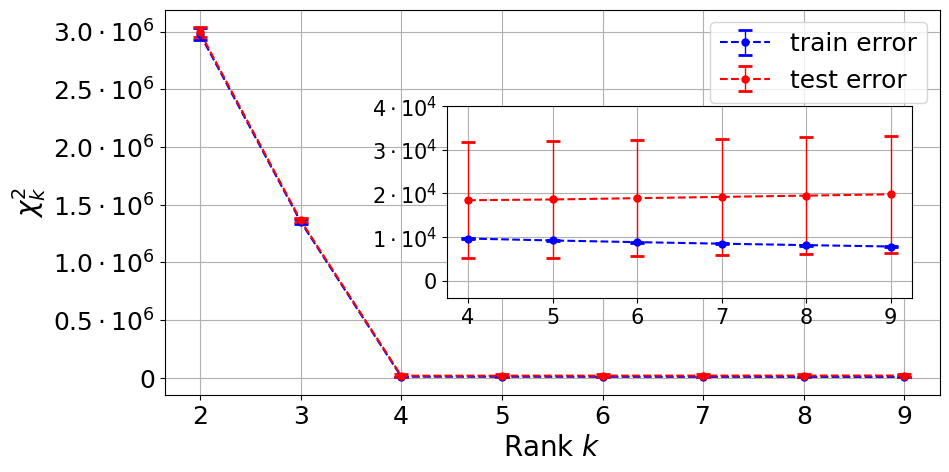

In [48]:
### chi^2 plot to compare the results with trained and tested sets for different ranks

chisq_mean_train = np.zeros(rank_length+1)
chisq_std_train = np.zeros(rank_length+1)

chisq_mean_test = np.zeros(rank_length+1)
chisq_std_test = np.zeros(rank_length+1)

for rank in range(0,final_rank-first_rank+1,1):
    chisq_mean_train[rank] = np.mean(chisq_values_train[:,rank])
    chisq_std_train[rank] = np.std(chisq_values_train[:,rank])    
    chisq_mean_test[rank] = np.mean(chisq_values_test[:,:,rank])
    chisq_std_test[rank] = np.std(chisq_values_test[:,:,rank])

fig, ax = plt.subplots(figsize=(10, 5))
ax.errorbar(range(2,10), chisq_mean_train, yerr=chisq_std_train, fmt='o', linestyle='--', color='b', capsize=5, capthick=2, elinewidth=1, markersize=4, markeredgewidth=2, label='train error')
ax.errorbar(range(2,10), chisq_mean_test, yerr=chisq_std_test, fmt='o', linestyle='--', color='r', capsize=5, capthick=2, elinewidth=1, markersize=4, markeredgewidth=2, label='test error')
ax.set_xlabel('Rank $k$', fontsize=20)
#plt.xticks(ticks=train_run_nums, labels=[f'{i+1}' for i in train_run_nums])  
ax.set_ylabel('$ \chi_k^2 $',fontsize=20)
# ax.ticklabel_format(style='plain')
ax.set_yticks([0,500000,1000000,1500000,2000000,2500000,3000000],['0','$0.5\cdot 10^6$','$1.0\cdot 10^6$','$1.5\cdot 10^6$','$2.0\cdot 10^6$','$2.5\cdot 10^6$','$3.0\cdot 10^6$'])  
ax.tick_params(axis='both', which='major', labelsize=18)
#ax.set_ylim(500,600)
ax.legend()
plt.legend(fontsize=18) 
ax.grid(True)

ax_inset = inset_axes(plt.gca(), width="60%", height="50%", loc='center right', borderpad=2) 
ax_inset.errorbar(range(4,10), chisq_mean_train[2:], yerr=chisq_std_train[2:], linestyle='--', color='b', fmt='o', capsize=5, capthick=2, elinewidth=1, markersize=4, markeredgewidth=2)
ax_inset.errorbar(range(4,10), chisq_mean_test[2:], yerr=chisq_std_test[2:], linestyle='--', color='r', fmt='o', capsize=5, capthick=2, elinewidth=1, markersize=4, markeredgewidth=2)
ax_inset.set_yticks([0,10000,20000,30000,40000],['0','$1\cdot 10^4$','$2\cdot 10^4$','$3\cdot 10^4$','$4\cdot 10^4$'])  
ax_inset.tick_params(axis='both', which='major', labelsize=15)
#ax_inset.set_xlim(3.8, 9.2)  # Adjust x-axis range to focus on the last 5 points
ax_inset.set_ylim(-4000, 40000)  # Adjust y-axis range accordingly
ax_inset.grid(True)
#mark_inset(ax, ax_inset,1,2,linestyle='--')

# plt.savefig(f'fig-chisq-rank.png', format='png', dpi=300, bbox_inches='tight')
plt.show()

In [49]:
### change in chi^2:

chisq_diff = np.zeros((9,10,7))
chisq_diff_av = np.zeros(7)
chisq_diff_std = np.zeros(7)

for rank in range(0,7,1):
    #print(run)
    chisq_diff[:,:,rank] =  chisq_values_test[:,:,rank+1]-chisq_values_test[:,:,rank]
    chisq_diff_av[rank] = np.mean(chisq_diff[:,:,rank])
    chisq_diff_std[rank] = np.std(chisq_diff[:,:,rank])

print(chisq_diff_av,chisq_diff_std)

[-1.62986337e+06 -1.34701497e+06  1.72849243e+02  2.96933726e+02
  2.93935692e+02  2.93195416e+02  2.95312680e+02] [28676.54571963 17861.6817127     82.17576691    63.32930662
    53.72574019    40.26307639    37.42085421]


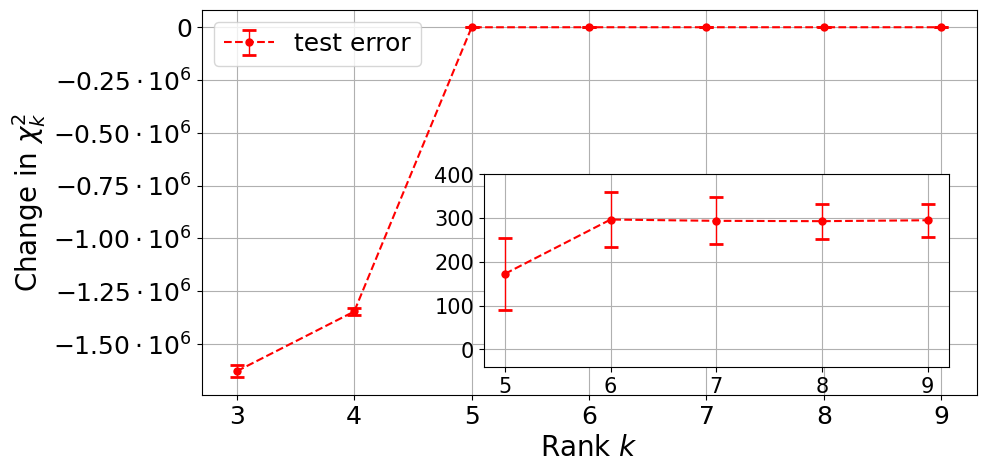

In [50]:
### change in chi^2 plot

fig, ax = plt.subplots(figsize=(10, 5))
ax.errorbar(range(3,10), chisq_diff_av, yerr=chisq_diff_std, fmt='o', linestyle='--', color='r', capsize=5, capthick=2, elinewidth=1, markersize=4, markeredgewidth=2, label='test error')
ax.set_xlabel('Rank $k$', fontsize=20)
#plt.xticks(ticks=train_run_nums, labels=[f'{i+1}' for i in train_run_nums])  
ax.set_ylabel('Change in $\chi^2_k $',fontsize=20)
ax.set_yticks([-1500000,-1250000,-1000000,-750000,-500000,-250000,0],['$-1.50\cdot 10^6$','$-1.25\cdot 10^6$','$-1.00\cdot 10^6$','$-0.75\cdot 10^6$','$-0.50\cdot 10^6$','$-0.25\cdot 10^6$','$0$'])  
ax.tick_params(axis='both', which='major', labelsize=18)
# ax.ticklabel_format(style='plain')
#ax.set_ylim(500,600)
ax.legend()
plt.legend(fontsize=18) 
ax.grid(True)

ax_inset = inset_axes(plt.gca(), width="60%", height="50%", loc=4, borderpad=2) 
ax_inset.errorbar(range(5,10), chisq_diff_av[2:], yerr=chisq_diff_std[2:], linestyle='--', color='r', fmt='o', capsize=5, capthick=2, elinewidth=1, markersize=4, markeredgewidth=2)
ax_inset.set_xticks([5,6,7,8,9])  
ax_inset.tick_params(axis='both', which='major', labelsize=15)
ax_inset.set_yticks([0,100,200,300,400])  
#ax_inset.set_xlim(3.8, 9.2)  # Adjust x-axis range to focus on the last 5 points
ax_inset.set_ylim(-40, 400)  # Adjust y-axis range accordingly
ax_inset.grid(True)
#mark_inset(ax, ax_inset,1,2,linestyle='--')

# plt.savefig(f'fig-change-in-chisq-rank.png', format='png', dpi=300, bbox_inches='tight')
plt.show()

# Step 3: Analysis including different times evolutions $\tau$ as preparations in the experiment

First, we load stack the data frequencies with different time evolution $\tau$ preparations and stack them into a single matrix

In [12]:
### load data and stack it into a supermatrix ###

# This time we have 7 experimental runs, 8 different time evolutions (including the not-waiting), and 1999 single-shots performed for each preparation and measurement
run_values = [1,2,3,4,5,6,7]
singleshots_number = 1999 # how many single-shots were performed to estimate each conditional probability
convergence_error = 1e-7 # convergence criteria for the see-saw. Increase for faster (but less accurate) results
rank = 4 # for this analysis we restrcit to rank = 4

for run_num in run_values:
    # stack data for all wait times:
    datafile = f'Data_with_time_evolution/zzzGPTwait0run{run_num}.csv'
    datamat = np.genfromtxt(datafile, delimiter=",")
    tau = [5000,10000,15000,20000,30000,40000,50000] # the waiting times $\tau$
    for t in tau:
        datafile = f'Data_with_time_evolution/zzzGPTwait{t}run{run_num}.csv'
        new = np.genfromtxt(datafile, delimiter=",") 
        datamat = np.vstack((datamat, new))

    # useful when needed
    cardinality_preparations = matrix_dimensions[0] # number of preparations
    cardinality_measurements = matrix_dimensions[1] # number of measurements
    Id_m = np.ones(cardinality_preparations) # for when we do not want these constraints on S and E.
    Id_n = np.ones(cardinality_measurements)
    Id_m = sp.sparse.diags(Id_m, 0, format='csr')
    Id_n = sp.sparse.diags(Id_n, 0, format='csr')   
    matrix_dimensions = datamat.shape # data dimension
    Wprime = sp.sparse.diags(oneoverW(datamat).flatten(('F')), 0, format='csr') # the variance of the loaded frequency table

    ### Compute the GPT model for the loaded data ###
    print('Computing see-saw for run ',run_num)
    current_states = np.random.rand(num_prep,rank) # initialize to random States
    current_effects = np.random.rand(rank,num_meas) # initialize to random Effects. check if the order is correct
    prob = np.dot(current_states, current_effects) # get their probability table
    quintuple = [current_states, current_effects, prob, datamat, rank]
    numerical_result = seesaw_optim(state_optim, effect_optim_NOAB, quintuple, convergence_error)
    
    # numerical_result returns the sixtuple [states, effects, prob = states.effects, data, rank, chi^2]
    state = numerical_result[0].copy()
    effect = numerical_result[1].copy()

    # save the output of the seesaw optimisation problem (the tuple containing states, effects, probabilities, data, rank, chi^2)
    filename = f'Data_with_time_evolution/stacked_seesaw_output{run_num}.csv'
    filepath = os.path.join(os.getcwd(), filename)
    
    result_contents = ['states', 'effects', 'prob', 'data', 'rank', 'chi^2']
    
    with open(filename, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        for title, item in zip(result_contents, numerical_result):
            writer.writerow([title])
            if isinstance(item, np.ndarray):
                for row in item:
                    writer.writerow(row)
            else:
                writer.writerow([item])
            writer.writerow([])  # Add a blank line between matrices

    ### evaluate the QR decomposition in the same way we did above ###
    # use the obtained states and effects to build D_realised
    Drealised = np.dot(state,effect)
    
    # make first column of Drealized ones
    Drealised = np.block([np.ones((len(Drealised),1)), Drealised.copy()])
    
    # obtain QR decomposition of Drealized and scale
    Q, R = np.linalg.qr(Drealised)
    Dprealised = np.dot(Q,R)
    c = Q[0,0]
    Qprime = Q/c
    Rprime = c*R
    
    # Partition matrices
    Q0 = np.array([Qprime[:,0]]).copy().T # instead of getting a 1D array (just doing Qprime[:,0]), I am forcing it to be a column vector (2D-array)
    Q1 = np.delete(Qprime, 0, axis=1).copy()
    
    R0 = np.array([Rprime[0,:]]).copy()
    R1 = np.delete(Rprime, 0, axis=0).copy()
    
    # Singular value decomposition
    tmp_matrix = np.dot(Q1,R1)
    U, Sigma, V = np.linalg.svd(tmp_matrix)
    V = V.T
    Sigma = np.diag(Sigma) # making it actually a matrix, instead of the array that builds the diag matrix
    
    # The parts of the SVD we are interested in
    U_int = U[:,0:rank-1].copy()
    Sigma_int = Sigma[0:rank-1,0:rank-1].copy()
    V_int = V[:,0:rank-1].copy()
    
    # Obtain Srealized and Erealized
    Sprealised = np.block([Q0, np.dot(U_int,np.sqrt(Sigma_int))])
    Eprealised = np.block([[R0], [np.dot(np.sqrt(Sigma_int), V_int.T)]]) # E does not have correct form (unit as first column)

    # For each tau, save S realised in a .csv file
    tau_list = [0,5000,10000,15000,20000,30000,40000,50000]
    for time in range(0,8):
        tau = tau_list[time]
        filename = f'Data_with_time_evolution/stacked_S_realised{run_num}_{tau}.csv'
        filepath = os.path.join(os.getcwd(), filename)
        with open(filepath, 'w', newline='') as csvfile:
            csvwriter = csv.writer(csvfile)
            csvwriter.writerows(Sprealised[100*time:100*(time+1),:]) 

    unit_e = [1,0,0,0]
    unit_matrix = np.array([unit_e]*len(Eprealised.T))
    Eprealised = np.append(Eprealised,unit_matrix.T-Eprealised,axis=1)

    # Save S and E realised as .csv files
    filename = f'Data_with_time_evolution/stacked_S_realised{run_num}.csv'
    filepath = os.path.join(os.getcwd(), filename)
    with open(filepath, 'w', newline='') as csvfile:
        csvwriter = csv.writer(csvfile)
        csvwriter.writerows(Sprealised) 
    filename = f'Data_with_time_evolution/stacked_E_realised{run_num}.csv'
    filepath = os.path.join(os.getcwd(), filename)
    with open(filepath, 'w', newline='') as csvfile:
        csvwriter = csv.writer(csvfile)
        csvwriter.writerows(Eprealised) 
        
    ### look for the corresponding consistent states and effects sets S_consistent, E_consistent
    # Compute S consistent
    A = np.vstack((-Eprealised.T,Eprealised.T))
    b=np.array([np.zeros(len(Eprealised.T)),np.ones(len(Eprealised.T))]).reshape(2*len(Eprealised.T),1)
    A = -np.array(A)
    b = np.array(b)
    M = np.hstack((b,A))
    Spconsistent = dual_space(M,len(Eprealised))

    # Compute E consistent
    C = np.vstack((-Sprealised,Sprealised))
    d=np.array([np.zeros(len(Sprealised)),np.ones(len(Sprealised))]).reshape(2*len(Sprealised),1)
    C = -np.array(C)
    d = np.array(d)
    N = np.hstack((d,C))
    Epconsistent = dual_space(N,len(Sprealised.T))

    # Save S and E consistent as .csv files
    filename = f'Data_with_time_evolution/stacked_S_consistent{run_num}.csv'
    filepath = os.path.join(os.getcwd(), filename)
    with open(filepath, 'w', newline='') as csvfile:
        csvwriter = csv.writer(csvfile)
        csvwriter.writerows(Spconsistent) 
    filename = f'Data_with_time_evolution/stacked_E_consistent{run_num}.csv'
    filepath = os.path.join(os.getcwd(), filename)
    with open(filepath, 'w', newline='') as csvfile:
        csvwriter = csv.writer(csvfile)
        csvwriter.writerows(Epconsistent) 

Computing see-saw for run  1
Rank = 4. Current Chi^2 = 5720651.942282241
Rank = 4. Current Chi^2 = 439734.81343644025
Rank = 4. Current Chi^2 = 169024.97575927761
Rank = 4. Current Chi^2 = 168929.91954912385
Rank = 4. Current Chi^2 = 168929.88151998582
Rank = 4. Current Chi^2 = 168929.88150461946
Rank = 4. Current Chi^2 = 168929.8815046132
Rank = 4. Converged to Chi^2 = 168929.8815046132
Computing see-saw for run  2
Rank = 4. Current Chi^2 = 5578266.405193878
Rank = 4. Current Chi^2 = 1928857.597176762
Rank = 4. Current Chi^2 = 147372.16756815434
Rank = 4. Current Chi^2 = 147251.8119149077
Rank = 4. Current Chi^2 = 147251.79339926454
Rank = 4. Current Chi^2 = 147251.7933957003
Rank = 4. Current Chi^2 = 147251.79339569944
Rank = 4. Converged to Chi^2 = 147251.79339569944
Computing see-saw for run  3
Rank = 4. Current Chi^2 = 4002738.204759144
Rank = 4. Current Chi^2 = 152539.78507079938
Rank = 4. Current Chi^2 = 145661.09931295714
Rank = 4. Current Chi^2 = 145660.13607734544
Rank = 4. C

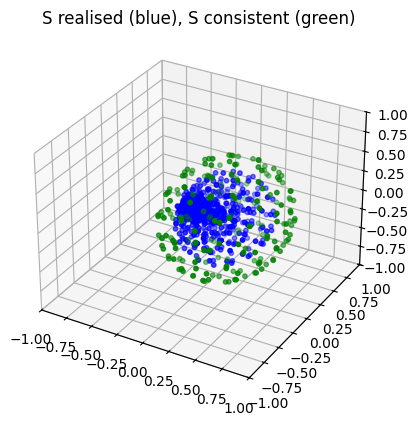

In [56]:
### example to load and visualize pre-computed data

# load S and E realized from pre-computed data
run_num = 1 # lets load the first experimental run, for illustrative purposes

# load states realised
filename = f'Data_with_time_evolution/stacked_S_realised{run_num}.csv'
filepath = os.path.join(os.getcwd(), filename)
Sprealised = np.genfromtxt(filepath, delimiter=",") 

# get components to plot
Srx = Sprealised[:, 1]
Sry = Sprealised[:, 2]
Srz = Sprealised[:, 3]

# load effects realised
filename = f'Data_with_time_evolution/stacked_E_realised{run_num}.csv'
filepath = os.path.join(os.getcwd(), filename)
Eprealised = np.genfromtxt(filepath, delimiter=",") 

# load states consistent
filename = f'Data_with_time_evolution/stacked_S_consistent{run_num}.csv'
filepath = os.path.join(os.getcwd(), filename)
Spconsistent = np.genfromtxt(filepath, delimiter=",") 

# get components to plot
Scx = Spconsistent[:, 1]
Scy = Spconsistent[:, 2]
Scz = Spconsistent[:, 3]

# Plot state spaces
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(Srx,Sry,Srz, marker='o',s=10, c='blue')
ax.scatter(Scx,Scy,Scz, marker='o',s=10, c='green')
plt.title('S realised (blue), S consistent (green)')
#ax.view_init(0., 0)
ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])
ax.set_zlim([-1, 1])
# plt.savefig(f'Src{run_num}.png', format='png')
plt.show()

# Step 4: Normalize the state spaces with respect to the consistent effect space E_consistent

In order to compare the different state spaces S_realized, it is desirable to have a normalization applied to all sets. The approach we choose is to use the fact that all their effect spaces consistent are, in principle, the same (since the effects applied on the experiment are always the same). Therefore, We use the fact that S_consistent (the dual of E_consistent) should be close to a unit ball in order to find a suitable transformation that brings the found set as close to a unit ball as possible. We then apply this same transformation to all S_realized sets considered. The transformation is split in two steps: first we apply a translation on the set to center it, and second we find a rotation and scale that approximate the states to unit vectors. As a precaution, we also define and run a function to remove all interior points of the given set and use only the boundary points. See text for details

First we need the experimental data. It can be computed above or we can load pre-computed data as follows:

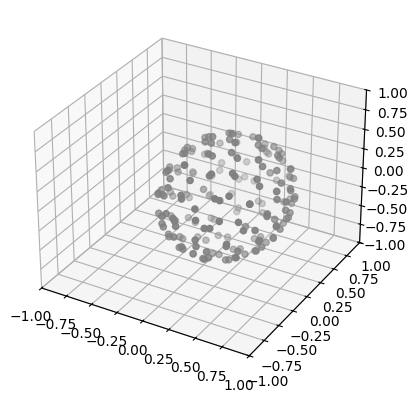

In [61]:
# As an example, load S and E consistent from pre-computed data

run_num = 1 # this is our arbitrary label for the experimental run

# load effects consistent
filename = f'Data_with_time_evolution/stacked_E_consistent{run_num}.csv'
filepath = os.path.join(os.getcwd(), filename)

Econsistent = np.genfromtxt(filepath, delimiter=",") 

# load states consistent
filename = f'Data_with_time_evolution/stacked_S_consistent{run_num}.csv'
filepath = os.path.join(os.getcwd(), filename)

Sconsistent = np.genfromtxt(filepath, delimiter=",") 

# plot
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(Sconsistent[:,1], Sconsistent[:,2], Sconsistent[:,3], color='grey')
ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])
ax.set_zlim([-1, 1])
# ax.view_init(0., 0) # point of view
plt.show()

We are now ready to find the transformation:

197

196

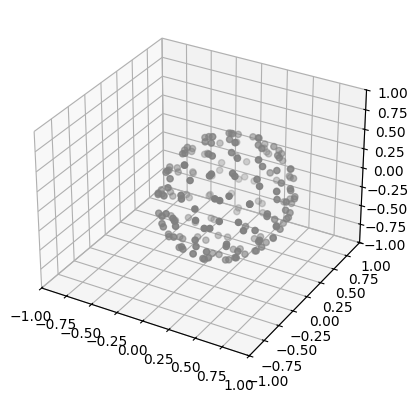

In [63]:
# (optional) Remove interior points of the states as a precautionary step. In our case it will just remove the 0th vector
SconsistentBoundary = remove_interior_points(Sconsistent)
display(len(Sconsistent)) # original number of states
display(len(SconsistentBoundary)) # new number of states

# plot
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(SconsistentBoundary[:,1], SconsistentBoundary[:,2], SconsistentBoundary[:,3], color='grey')
ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])
ax.set_zlim([-1, 1])
#ax.scatter(Sconsistent[:,1], Sconsistent[:,2], Sconsistent[:,3], color='grey') # to compare with the original
# ax.view_init(0., 90) # point of view
plt.show()

In [64]:
### evaluate the transformation explained above (or in the text in more detail)
res = find_transformation(Sconsistent)
(res.fun)/len(Sconsistent) # this shows the average distance away from unity that the norm of each state has. The closer to zero the better the approximation to a unit sphere

np.float64(0.0021635220797791223)

In [65]:
# the resulting variables for the transformation
variables = res.x
Sigma = np.diag([variables[0], variables[1], variables[2]])
alpha = variables[3]
beta = variables[4]
gamma = variables[5]
V = euler_angles_matrix(alpha,beta,gamma)

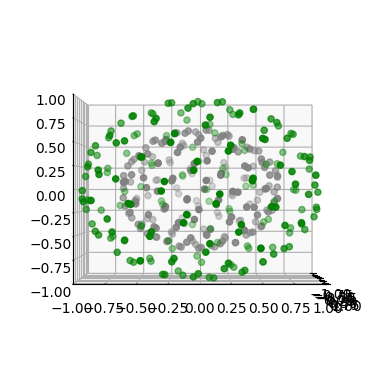

In [68]:
# apply and plot the transformation to S consistent

shift_t = np.mean(SconsistentBoundary[:,1:4], axis=0)
SconsistentTransformed = apply_transformation(SconsistentBoundary,Sigma,V,shift_t)

# plot
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(SconsistentTransformed[:,0], SconsistentTransformed[:,1], SconsistentTransformed[:,2], color='green')
ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])
ax.set_zlim([-1, 1])
ax.scatter(SconsistentBoundary[:,1], SconsistentBoundary[:,2], SconsistentBoundary[:,3], color='grey') # to compare with the original
ax.view_init(0., 0) # point of view
plt.show()

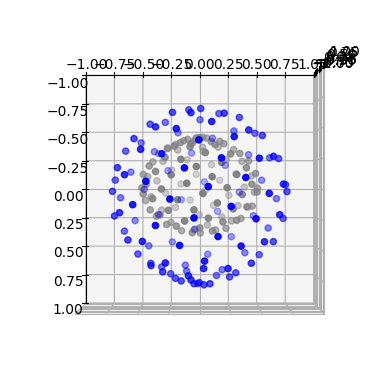

In [70]:
# (illustrativee example) How to apply and plot the previously found transformation to some given S_realized

# load and transform the data, in our case States_realized
run_num = 1
filename = f'Data_with_time_evolution/stacked_S_realised{run_num}.csv'
filepath = os.path.join(os.getcwd(), filename)
Srealised = np.genfromtxt(filepath, delimiter=",") 

SrealisedBoundary = remove_interior_points(Srealised)
SrealisedTransformed = apply_transformation(SrealisedBoundary,Sigma,V,shift_t)

# plot to compare before and after the transformation
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(SrealisedTransformed[:,0], SrealisedTransformed[:,1], SrealisedTransformed[:,2],color='blue')
ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])
ax.set_zlim([-1, 1])
ax.scatter(SrealisedBoundary[:,1], SrealisedBoundary[:,2], SrealisedBoundary[:,3],color='grey') # to compare with the original
ax.view_init(90., 0) # point of view
plt.show()


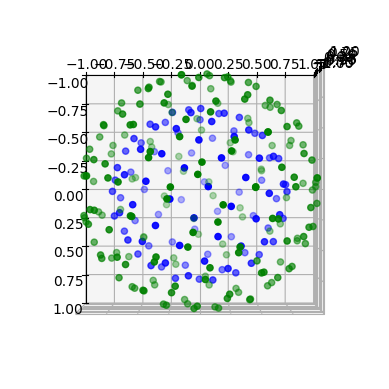

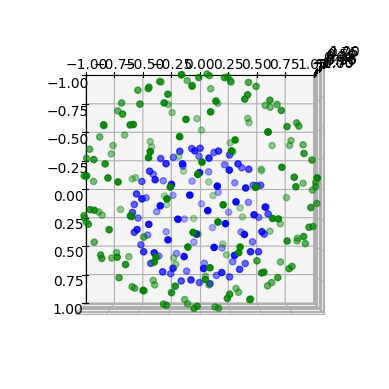

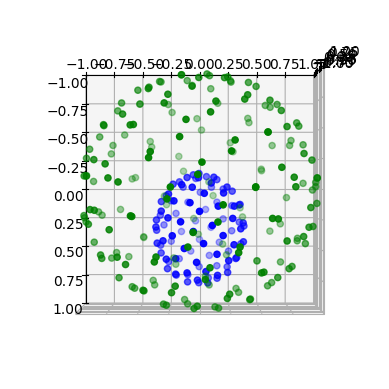

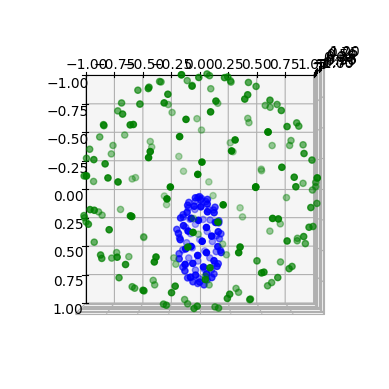

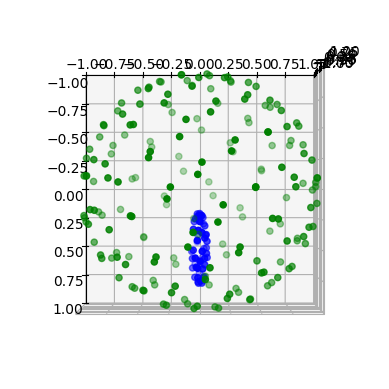

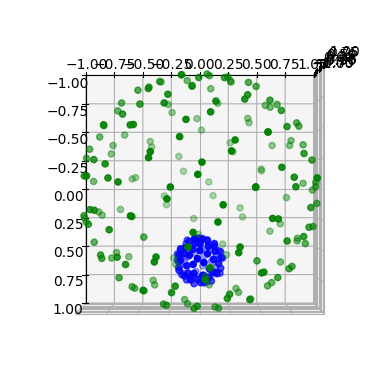

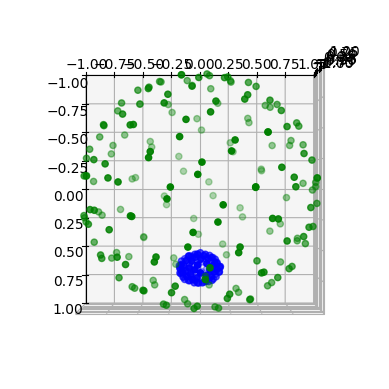

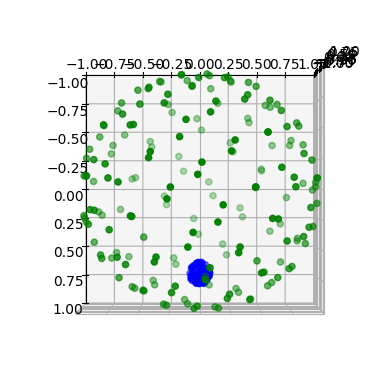

In [72]:
# Iteratively apply and plot the transformation to different S realized
# as of now you need to have found a transformation in a previous step

tau_values = [0,5000,10000,15000,20000,30000,40000,50000] # the evolution time values performed in the experiment as part of the preparations

# iteratively evaluate, store and plot
for tau_num in tau_values: 
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    ax.set_xlim([-1, 1])
    ax.set_ylim([-1, 1])
    ax.set_zlim([-1, 1])
    filename = f'Data_with_time_evolution/stacked_S_realised{run_num}_{tau_num}.csv'
    filepath = os.path.join(os.getcwd(), filename)
    Srealised = np.genfromtxt(filepath, delimiter=",") 
    SrealisedBoundary = remove_interior_points(Srealised)
    SrealisedTransformed = apply_transformation(SrealisedBoundary,Sigma,V,shift_t) 
    #SrealisedTransformed -= shift_t
    ax.scatter(SconsistentTransformed[:,0], SconsistentTransformed[:,1], SconsistentTransformed[:,2], color='green')
    ax.scatter(SrealisedTransformed[:,0], SrealisedTransformed[:,1], SrealisedTransformed[:,2],color='blue')

    stacked_S_r_transformed = f'Data_with_time_evolution/transformed_stacked_S_r{run_num}_{tau_num}.csv'
    filepath = os.path.join(os.getcwd(), stacked_S_r_transformed)
    
    with open(filepath, 'w', newline='') as csvfile:
        csvwriter = csv.writer(csvfile)
        csvwriter.writerows(SrealisedTransformed) 
    
    ax.view_init(90, 0) # point of view
    plt.show()

# Step 5: Compute the volume of the state spaces for various time evolutions, examining how the volume changes as the qubit decoheres.

In [40]:
# (optional) It assumes that the normalization transformation has been already computed, otherwise run:

# get transformation to normalize
res = find_transformation(SconsistentBoundary)
variables = res.x
translationSconsistent = np.mean(SconsistentBoundary, axis=0)
Sigma = np.diag([variables[0], variables[1], variables[2]])
alpha = variables[3]
beta = variables[4]
gamma = variables[5]
V = euler_angles_matrix(alpha,beta,gamma)

In [42]:
# Compute the volume of the State Spaces corresponding to different time evolutions Tau to compare
# We use the delaunay triangulation to split the state space polytope into simplices for which we know their volume formula. Then we just add the volumes of all simplices

from scipy.spatial import Delaunay

def tetrahedron_volume(a, b, c, d):
    return np.abs(np.einsum('ij,ij->i', a-d, np.cross(b-d, c-d))) / 6

vol_c = [0]*7
vol = [[0]*7 for i in range(8)] # initialize the array gathering the volumes, rows are the Tau, columns the experimental run

# compute the vol for subsequent Tau's
Taus = [0, 5000, 10000, 15000, 20000, 30000, 40000, 50000]

for j in range(1,8):
    data_num = j # which experimental run
    filename = f'stacked_S_consistent{data_num}.csv'
    filepath = os.path.join(os.getcwd(), filename)
    Sconsistent = np.genfromtxt(filepath, delimiter=",") 

    SconsistentBoundary = remove_interior_points(Sconsistent)
    res = find_transformation(SconsistentBoundary)
    variables = res.x
    translationSconsistent = np.mean(SconsistentBoundary, axis=0)
    Sigma = np.diag([variables[0], variables[1], variables[2]])
    alpha = variables[3]
    beta = variables[4]
    gamma = variables[5]
    V = euler_angles_matrix(alpha,beta,gamma)
    
    SconsistentTransformed = apply_transformation(Sconsistent - translationSconsistent,Sigma,V) 
    
    dt = Delaunay(SconsistentTransformed)
    tets = dt.points[dt.simplices]
    vol_c[j-1] = np.sum(tetrahedron_volume(tets[:, 0], tets[:, 1], tets[:, 2], tets[:, 3]))
    
    print ("Run = " + str(j) + "; consistent volume = " + str(vol_c[j-1]))
    
    for i in range (1,9): # iterate through taus
    
        filename = f'stacked_S_realised{data_num}.csv'
        filepath = os.path.join(os.getcwd(), filename)
        Srealised = np.genfromtxt(filepath, delimiter=",") 
            
        SrealisedTau = apply_transformation(Srealised[(i-1)*100:i*100,::] - translationSconsistent,Sigma,V) # the 100 preparations for Tau
        
        dt = Delaunay(SrealisedTau)
        tets = dt.points[dt.simplices]
        vol[i-1][j-1] = np.sum(tetrahedron_volume(tets[:, 0], tets[:, 1], tets[:, 2], tets[:, 3]))
        print ("Run = " + str(j) + "; tau = " + str(Taus[i-1]) + "; realised volume = " + str(vol[i-1][j-1]))

Run = 1; consistent volume = 3.9628867537385313
Run = 1; tau = 0; realised volume = 1.5394001200036427
Run = 1; tau = 5000; realised volume = 0.7250159876285158
Run = 1; tau = 10000; realised volume = 0.25501388770053435
Run = 1; tau = 15000; realised volume = 0.04993639159265252
Run = 1; tau = 20000; realised volume = 0.004620237917644536
Run = 1; tau = 30000; realised volume = 0.02830935248586429
Run = 1; tau = 40000; realised volume = 0.014947508355829413
Run = 1; tau = 50000; realised volume = 0.0022703004379473267
Run = 2; consistent volume = 3.961875545685753
Run = 2; tau = 0; realised volume = 1.6877992660705867
Run = 2; tau = 5000; realised volume = 0.6939694972226407
Run = 2; tau = 10000; realised volume = 0.21628166826083345
Run = 2; tau = 15000; realised volume = 0.04237625350662636
Run = 2; tau = 20000; realised volume = 0.008277996240064894
Run = 2; tau = 30000; realised volume = 0.029892923765755128
Run = 2; tau = 40000; realised volume = 0.015516629802541355
Run = 2; tau

In [48]:
# Show the mean of the volumes obtained from all the runs and their standard deviation

mean_volumes = np.mean(vol, axis=1)
std_deviations_volums = [np.std(vol[::][i]) for i in range(8)]
print(mean_volumes)
print(std_deviations_volums)

[1.67468682 0.72923656 0.22932043 0.03862322 0.00632298 0.03229285
 0.01697225 0.00243933]
[np.float64(0.05724509166954087), np.float64(0.02898553067008585), np.float64(0.012859155016304897), np.float64(0.00534042054964603), np.float64(0.0029258780887859944), np.float64(0.0027306524659911125), np.float64(0.001397791325965092), np.float64(0.0003043541231602063)]


In [49]:
mean_volume_c = np.mean(vol_c)
std_vol_c = np.std(vol_c)
print(mean_volume_c)
print(std_vol_c)

3.9604947601745946
0.002388983405836387


In [50]:
# Evaluate the relative volumes

rel_volumes = [[0]*7 for i in range(8)]
for i in range(1,9):
    for j in range(1,8):
        rel_volumes[i-1][j-1] = vol[i-1][j-1]/vol_c[j-1]

for j in range(0,8):
    print(rel_volumes[:][j])
relvol_means = np.mean(rel_volumes, axis=1)
relvol_std = [np.std(rel_volumes[:][j]) for j in range(8)]

[np.float64(0.3884542293698891), np.float64(0.4260101678126916), np.float64(0.43199917530012566), np.float64(0.43265773705698796), np.float64(0.43095918665051747), np.float64(0.42957952436568475), np.float64(0.42031028596882264)]
[np.float64(0.18295147771874784), np.float64(0.17516186190611974), np.float64(0.19022384354376054), np.float64(0.18863368741785208), np.float64(0.19296781411291145), np.float64(0.18731647283043784), np.float64(0.17166090880745294)]
[np.float64(0.06435053624985823), np.float64(0.054590727489244664), np.float64(0.05942823463351637), np.float64(0.05830678637530808), np.float64(0.05690582448654611), np.float64(0.05805449350765957), np.float64(0.05367878123802847)]
[np.float64(0.012601014032395257), np.float64(0.01069600824608728), np.float64(0.009713839599307687), np.float64(0.008849269804340868), np.float64(0.008571926386561887), np.float64(0.009090025440791863), np.float64(0.00874076212843971)]
[np.float64(0.0011658768480542294), np.float64(0.0020894134973722584

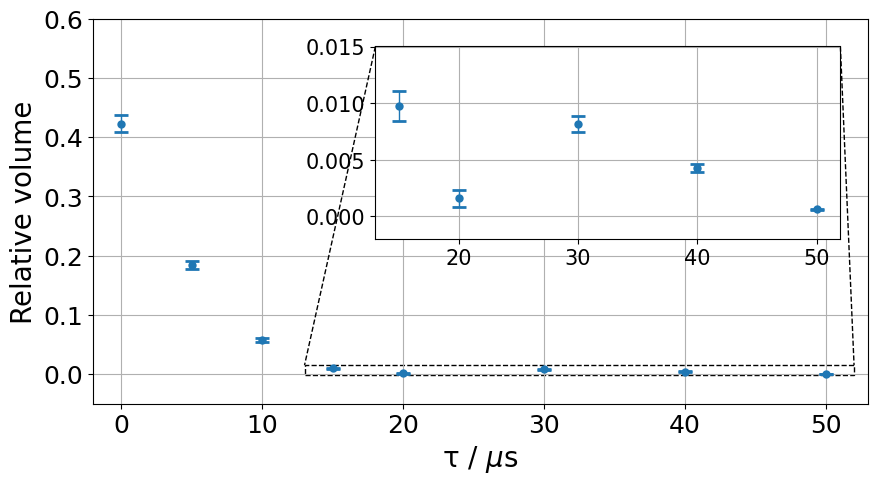

In [78]:
### relative volumes plot

taus_mu = [tau / 1000 for tau in Taus]
fig, ax = plt.subplots(figsize=(10, 5))
ax.errorbar(taus_mu, relvol_means, yerr=relvol_std, fmt='o', capsize=5, capthick=2, elinewidth=1, markersize=4, markeredgewidth=2)
ax.set_xlabel('τ / $\mu$s', fontsize=20)
ax.set_xlim(-2,53)
ax.set_ylim(-0.05,0.6)
ax.set_ylabel('Relative volume',fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=18)
#ax.set_xticks(Taus)
#ax.set_yticks(np.arange(-0, 0.6, 0.1))
#ax.legend()
ax.grid(True)

#inset axes
ax_inset = inset_axes(plt.gca(), width="60%", height="50%", loc='upper right', borderpad=2) 
ax_inset.errorbar(taus_mu[-5:], relvol_means[-5:], yerr=relvol_std[-5:], fmt='o', capsize=5, capthick=2, elinewidth=1, markersize=4, markeredgewidth=2)
ax_inset.set_xticks([20,30,40,50])  
ax_inset.tick_params(axis='both', which='major', labelsize=15)
ax_inset.set_xlim(taus_mu[-5]-2, taus_mu[-1]+2)  # Adjust x-axis range to focus on the last 5 points
ax_inset.set_ylim(-0.002, 0.015)  # Adjust y-axis range accordingly
ax_inset.grid(True)
mark_inset(ax, ax_inset,1,2,linestyle='--')

plt.savefig('fig_rel_volume.png', dpi=300, bbox_inches='tight')
plt.show()